# **HOUSE PRICING: Cross-validation, Hiperparametros**


Vamos a realizar un torneo de modelos con algunos modelos de regresión. Para ello utilizaremos un dataset de precios de propiedades en Ames, Iowa.

# Import libraries

In [ ]:
# Datos
import numpy as np
import pandas as pd

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from random import random

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

# Evaluacion
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

#Tamño default de los plots
plt.rcParams["figure.figsize"] = [10,6]

# Load dataset

Dataset source: https://www.perkinsml.me/ames-housing

El dataset House_Pricing contiene datos de compra-venta de viviendas  en Ames, Iowa recopilados por una agencia inmobiliaria:
* Precio (dolares)
* Area vivienda (m2)
* Antiguedad vivienda (años)
* Numero de Habitaciones
* Numero de Dormitorios
* Ingresos promedio de la zona (dolares)
* Densidad poblacional (hab/km2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SUPERVISED ML/NUCLIO DSC ML SUPERVISADO - Compartida/Notebooks/ML2 - Torneo de modelos, cross-validation y hiperparametros/House_Pricing_Ames.csv')
df.head()

,PRECIO,AREA,ANTIGUEDAD,HABITACIONES,DORMITORIOS,INGRESOS_ZONA,POBLACION_ZONA
0,317710.2,243.18,5.68,7.0,4.0,79545.46,23086.80
1,451767.3,234.83,6.00,7.0,3.0,79248.64,40173.07
2,317696.4,288.28,5.87,9.0,5.0,61287.07,36882.16
3,378185.1,200.50,7.19,6.0,3.0,63345.24,34310.24
4,189282.9,268.08,5.04,8.0,4.0,59982.20,26354.11


In [ ]:
df.shape

# ML Preprocessing

### Data cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PRECIO          5000 non-null   float64
 1   AREA            5000 non-null   float64
 2   ANTIGUEDAD      5000 non-null   float64
 3   HABITACIONES    5000 non-null   int8   
 4   DORMITORIOS     5000 non-null   int8   
 5   INGRESOS_ZONA   5000 non-null   float64
 6   POBLACION_ZONA  5000 non-null   float64
dtypes: float64(5), int8(2)
memory usage: 205.2 KB


In [ ]:
#Corregimos formatos
df.HABITACIONES = df.HABITACIONES.astype('int8')
df.DORMITORIOS = df.DORMITORIOS.astype('int8')

### EDA: Análisis exploratorio

* En datasets con POCAS VARIABLES (como es el caso) podemos permitirnos explorar visualmente las distribuciones de las variables (analisis univariable) y de las relaciones entre variables (analisis multivariable) para tener mas conocimiento de los datos.
* En datasets con MUCHAS VARIABLES (>20) obviaremos este paso pues el analisis visual se vuelve complejo y no ayuda.

In [ ]:
target = 'PRECIO'
features = df.columns[df.columns!=target]

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRECIO,5000.0,369621.797640,105935.287688,4781.70,299273.1750,369800.700,441363.0000,740719.80
AREA,5000.0,242.534648,30.175065,129.99,221.8775,242.990,262.8775,355.69
ANTIGUEDAD,5000.0,5.977278,0.991437,2.64,5.3200,5.970,6.6500,9.52
HABITACIONES,5000.0,6.988400,1.044262,3.00,6.0000,7.000,8.0000,11.00
DORMITORIOS,5000.0,3.741200,1.228057,2.00,3.0000,4.000,4.0000,6.00
INGRESOS_ZONA,5000.0,68583.108950,10657.991228,17796.63,61480.5650,68804.285,75783.3425,107701.75
POBLACION_ZONA,5000.0,36163.516088,9925.650059,172.61,29403.9300,36199.405,42861.2900,69621.71


In [ ]:
target = 'PRECIO'
features = df.columns[df.columns!=target]

# Divide dataset en matriz de variables (X) y output (y)
X = df[features]
y = df[target]

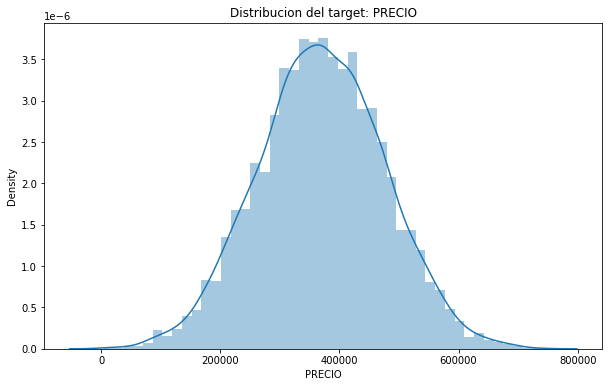

In [ ]:
#Distribucion target
sns.distplot(y)
plt.title('Distribucion del target: '+target)
plt.show()

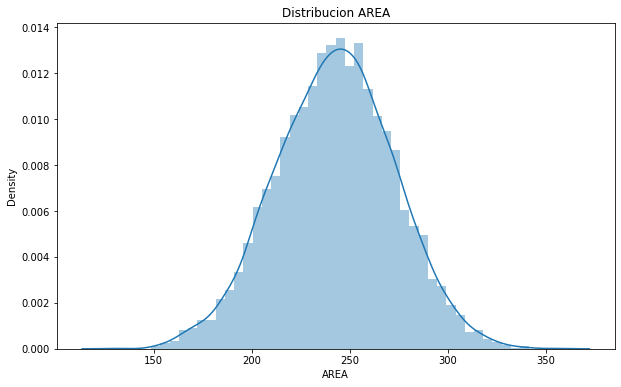

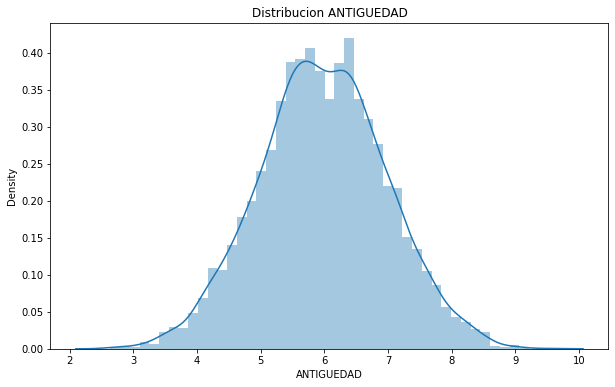

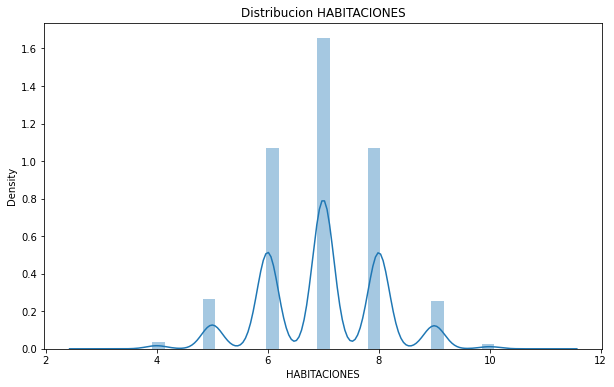

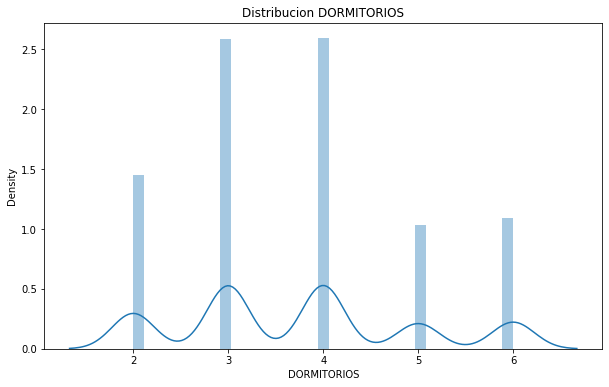

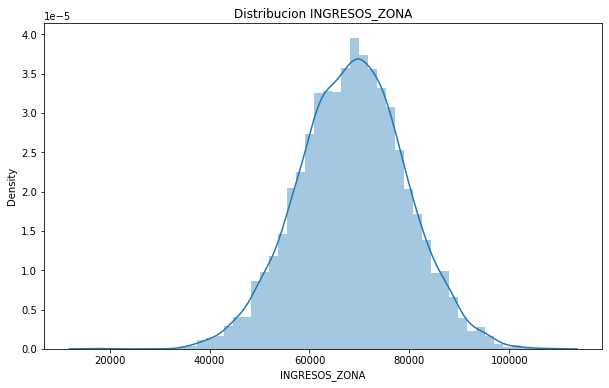

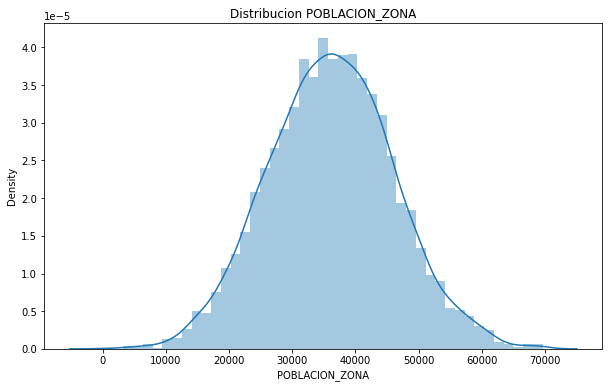

In [ ]:
for i in features:
  sns.distplot(X[i])
  plt.title('Distribucion '+i)
  plt.show()

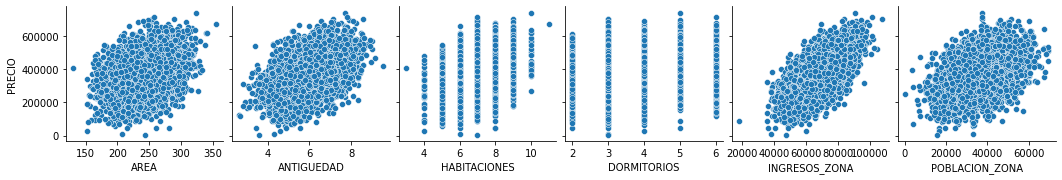

In [ ]:
#Dispersion target-variable
sns.pairplot(df,x_vars=features, y_vars=target)
plt.show()

### Gestionar nulos

In [ ]:
df.isna().sum()

PRECIO            0
AREA              0
ANTIGUEDAD        0
HABITACIONES      0
DORMITORIOS       0
INGRESOS_ZONA     0
POBLACION_ZONA    0
dtype: int64

### Eliminar variables altamente correlacionadas

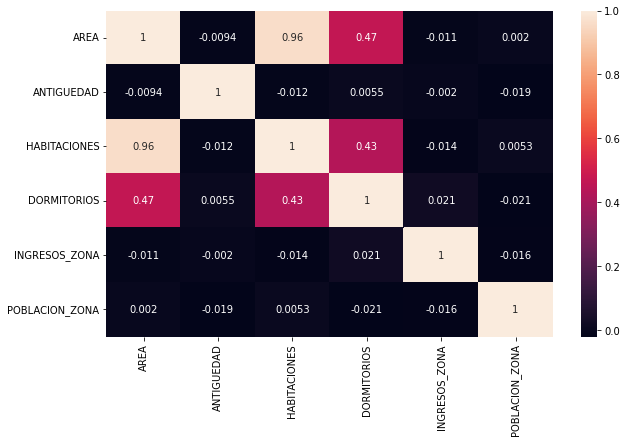

In [ ]:
sns.heatmap(X.corr(),annot=True)
plt.show()

In [ ]:
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

highly_corr = highly_correlated(X,y,0.95)
highly_corr

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete
0,HABITACIONES,AREA,0.961175,0.321108,0.335664,HABITACIONES


In [ ]:
# Eliminamos las features altamente correlacionadas
X.drop(axis=1, columns=highly_corr['F_to_delete'], inplace=True)

In [ ]:
X.head(3)

,AREA,ANTIGUEDAD,DORMITORIOS,INGRESOS_ZONA,POBLACION_ZONA
0,243.18,5.68,4,79545.46,23086.80
1,234.83,6.00,3,79248.64,40173.07
2,288.28,5.87,5,61287.07,36882.16


### Eliminar variables baja varianza

In [ ]:
vt = VarianceThreshold(threshold = 0.01) #Eliminamos columnas donde el 99% de los valores son iguales
vt.fit(X)

cols_lowvar = X.columns[vt.get_support()==False]
X.drop(columns=cols_lowvar,inplace=True)

print(len(cols_lowvar),' low variance features were removed:\n', cols_lowvar.to_list())

0  low variance features were removed:
 []


### Split train-test

Para el test dejamos entre un 10%-30% del dataset original. 10% cuando el dataset es pequeño (<10k), 20-30% cuando el dataset es grande (>100k). En este caso tenemos 5k observaciones por lo que utilizaremos 10%.

In [ ]:
# Divide X-y en Train (90%) y Test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)

In [ ]:
print('Train set size:',X_train.shape[0])
print('Test set size:',X_test.shape[0])

Train set size: 4250
Test set size: 750


### Estandarizacion

In [ ]:
# Estandarización: fit_transform() en train, transform() en test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelo

**K-Fold Cross validation**<br>
Devuelve el predict promedio de k modelos entrenados con distintas particiones para el test. Es más fiable y robusto sobre todo en datasets pequeños.

* La metrica del score la dicta cada modelo. Ver documentacion de cada modelo en scikitlearn para saber qué metrica es el score. Por defecto en regresion suele ser el R2-score pero podemos utilizar otras metricas: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
-np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))

30252.57172939905

Para la proxima parte vamos a crear funciones que nos ayuden a evaluar el error rapidamente en los diferentes modelos:

In [ ]:
def RMSE(model,X,y):
  return round(np.sqrt(np.mean((y-model.predict(X))**2)),2)

def cross_val(model,X,y):
  Kfold_rmse = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
  return round(-Kfold_rmse.mean(),2)

# Model Competition

In [ ]:
# Modelos ML de Regresion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

Hemos visto como implementar un modelo de Regresión Lineal y como interpretarlo pero ¿como saber que este modelo es el mejor modelo para la naturaleza de nuestros datos? Vamos a probar que tal se le da a otros modelos!

In [ ]:
# Inicializa resultados
label_ = []
rmse_train_ = []
rmse_valida_ = []

# Funcion que devuelve un dataframe con resultados de RMSE Cross Validation
def evaluate_regression(label,model, X, y, verbose=True, cv=True):

  model.fit(X,y)
  rmse_train = RMSE(model,X,y)
  cross_valida = cross_val(model,X,y)

  label_.append(label)
  rmse_train_.append(rmse_train)
  if cv==True:
    rmse_valida_.append(cross_valida)
  else:
    rmse_valida_.append(-1)

  if verbose==True:
    return pd.DataFrame({'Model': label_,
                       'RMSE Train': rmse_train_,
                       'RMSE Cross-Valida': rmse_valida_
                       }).sort_values('RMSE Cross-Valida')

In [ ]:
evaluate_regression(label='Linear Regression',
                    model = LinearRegression(),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
0,Linear Regression,30227.31,30252.57


## Regresión Lineal + Regularización: LASSO, Ridge y ElasticNet

In [ ]:
evaluate_regression(label='Lasso',
                    model = Lasso(alpha=0.01),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57


In [ ]:
evaluate_regression(label='Ridge',
                    model = Ridge(alpha=0.3),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57


In [ ]:
evaluate_regression(label='Elastic Net (l1=0.5)',
                    model = ElasticNet(l1_ratio=0.5),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57
3,Elastic Net (l1=0.5),45785.13,45818.92


## Polynomial Regression

In [ ]:
poly_reg = PolynomialFeatures(degree=3)

#Trasformamos el dato para que la ecuacion de la regresion lineal se ajuste a una expresion polinomica: X^3 + X^2 + X + 1
X_train_poly = poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.transform(X_test)
X_poly = poly_reg.transform(X)

In [ ]:
X_train_poly.shape

(4250, 56)

In [ ]:
evaluate_regression(label='Polynomial d=3',
                    model = LinearRegression(),
                    X=X_train_poly, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57
4,Polynomial d=3,30049.63,30488.14
5,Polynomial d=3,30049.63,30488.14
3,Elastic Net (l1=0.5),45785.13,45818.92


## Stochastic Gradient Descent

In [ ]:
evaluate_regression(label='SGD (eta0=0.01)',
                    model = SGDRegressor(n_iter_no_change=100, penalty=None, eta0=0.01, max_iter=10000),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
7,SGD (eta0=0.01),30229.16,30250.76
6,SGD,30227.31,30252.54
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57
4,Polynomial d=3,30049.63,30488.14
5,Polynomial d=3,30049.63,30488.14
3,Elastic Net (l1=0.5),45785.13,45818.92


## Random Forest Regressor

In [ ]:
evaluate_regression(label='Random Forest',
                    model = RandomForestRegressor(n_estimators=1000, max_depth=3),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
7,SGD (eta0=0.01),30229.16,30250.76
6,SGD,30227.31,30252.54
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57
4,Polynomial d=3,30049.63,30488.14
5,Polynomial d=3,30049.63,30488.14
3,Elastic Net (l1=0.5),45785.13,45818.92
8,Random Forest,65960.38,67407.08


## Support Vector Regressor (SVR)

In [ ]:
evaluate_regression(label='SVR',
                    model = SVR(kernel='rbf', C=1000000, epsilon=0.001),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
7,SGD (eta0=0.01),30229.16,30250.76
6,SGD,30227.31,30252.54
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57
4,Polynomial d=3,30049.63,30488.14
5,Polynomial d=3,30049.63,30488.14
9,SVR,28673.45,33627.13
3,Elastic Net (l1=0.5),45785.13,45818.92
8,Random Forest,65960.38,67407.08


## KNN Regressor

In [ ]:
evaluate_regression(label='KNN (k=10)',
                    model = KNeighborsRegressor(n_neighbors = 10),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
7,SGD (eta0=0.01),30229.16,30250.76
6,SGD,30227.31,30252.54
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57
4,Polynomial d=3,30049.63,30488.14
5,Polynomial d=3,30049.63,30488.14
9,SVR,28673.45,33627.13
10,KNN (k=10),33526.58,37695.71
3,Elastic Net (l1=0.5),45785.13,45818.92


## XGBoost Regressor

In [ ]:
evaluate_regression(label='XGBoost',
                    model = XGBRegressor(objective ='reg:squarederror'),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Valida
7,SGD (eta0=0.01),30229.16,30250.76
6,SGD,30227.31,30252.54
0,Linear Regression,30227.31,30252.57
1,Lasso,30227.31,30252.57
2,Ridge,30227.31,30252.57
4,Polynomial d=3,30049.63,30488.14
5,Polynomial d=3,30049.63,30488.14
11,XGBoost,28634.08,33162.53
9,SVR,28673.45,33627.13
10,KNN (k=10),33526.58,37695.71


**NOTA:** Tambien se probó una Red Neuronal ANN y el resultado fue RMSE_TEST = 127795.59 ...

# Hiperparametros

Vamos a utilizar RandomSearch para obtener la mejor configuración del modelo ganador: el Stochastic Gradient Descent (SGD).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
parameters_hp = {
    'penalty': [None,'l1','l2'],
    'alpha': [0.0001, 0.01,0.1,0.5],
    'l1_ratio': [0.15, 0.5],
    'max_iter': [1000,10000] ,
    'learning_rate': ['invscaling', 'optimal', 'adaptative'],
    'eta0': [0.01,0.05,0.1],
    'early_stopping': [True,False],
    'n_iter_no_change': [5,10,30]
}

In [ ]:
search_hp = RandomizedSearchCV(estimator=SGDRegressor(),
                               param_distributions = parameters_hp,
                               scoring='neg_root_mean_squared_error',     # metrica a optimizar: RMSE
                               cv = 5,                                    # numero de folds para cross-validation
                               n_iter = 200,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               verbose=True)

In [ ]:
search_hp.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=SGDRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.01, 0.1, 0.5],
                                        'early_stopping': [True, False],
                                        'eta0': [0.01, 0.05, 0.1],
                                        'l1_ratio': [0.15, 0.5],
                                        'learning_rate': ['invscaling',
                                                          'optimal',
                                                          'adaptative'],
                                        'max_iter': [1000, 10000],
                                        'n_iter_no_change': [5, 10, 30],
                                        'penalty': [None, 'l1', 'l2']},
                   scoring='neg_root_mean_squared_error', verbose=True)

In [ ]:
print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best RMSE:", -search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: SGDRegressor(early_stopping=True, max_iter=10000, n_iter_no_change=10,
             penalty=None)

 The best RMSE: 30232.418990716444

 The best parameters across ALL searched params:
 {'penalty': None, 'n_iter_no_change': 10, 'max_iter': 10000, 'learning_rate': 'invscaling', 'l1_ratio': 0.15, 'eta0': 0.01, 'early_stopping': True, 'alpha': 0.0001}


El unico problema de RandomSearch es que no podemos elegir las configuraciones a probar y podria dar con un ajuste de parametros que no es mejor que la configuración por defecto. Asi que es recomendable siempre comprobar que se mejora el  performance que se obtuvo con la configuracion default en la Competicion de Modelos.

# Modelo final

In [ ]:
model = search_hp.best_estimator_

# Evaluación TEST

### Evaluación del error

Veamos en detalle el error que produce el modelo en los datos de Test

In [ ]:
y_train_pred = model.predict(X_train)              # predicciones del modelo en los datos de TRAIN
y_test_pred = model.predict(X_test)                # predicciones del modelo en los datos de TEST

* **RMSE, MAE y MAPE**

In [ ]:
error = y_test_pred - y_test.values

In [ ]:
mae = np.mean(np.abs(error))
mape = np.mean(error/y_test)
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('MAPE: {:.3%}'.format(mape))
print('R2-Score: {:.2%}'.format(r2_score(y_test, y_test_pred)))

RMSE: 30958.9391
MAE: 24933.4379
MAPE: 0.815%
R2-Score: 91.57%


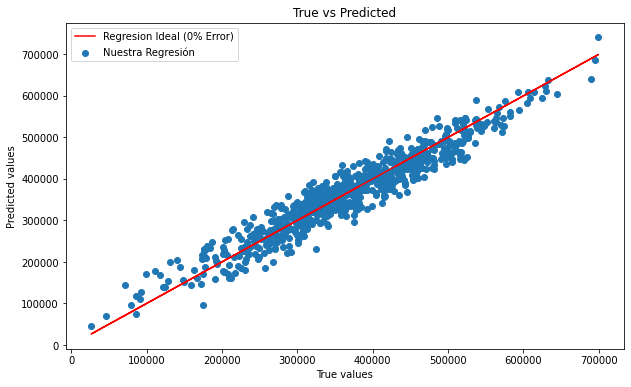

In [ ]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(y_test,y_test_pred)
plt.plot(y_test,y_test,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

**Distribución del error**

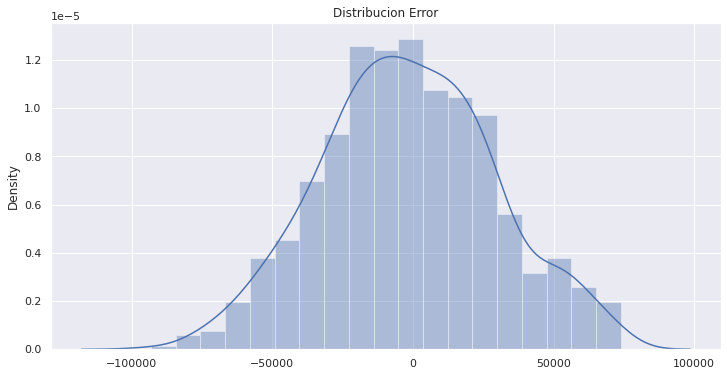

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

In [ ]:
round(pd.Series(error).describe(),2)

count      750.00
mean     -1680.95
std      30933.90
min     -93195.03
25%     -22358.33
50%      -1895.43
75%      18983.80
max      73877.68
dtype: float64

**Error interval:**

In [ ]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 59917.6 / -62631.3


# Interpretabilidad

Como el dataset fue estandarizado, los coeficientes resultantes de la regresion lineal corresponden a la importancia de cada variable en el resultado del modelo.

In [ ]:
model.coef_

array([37002.32699794, 49604.65107088,  1275.50978175, 68491.53049024,
       45216.10645325])

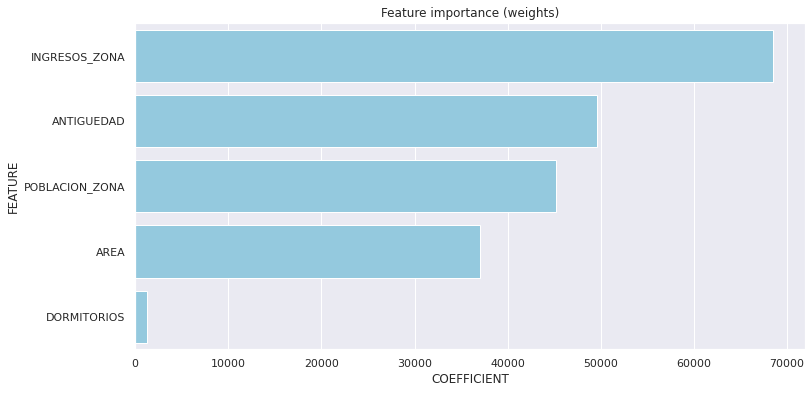

In [ ]:
df_coef = pd.DataFrame({'FEATURE':X.columns.values,
            'COEFFICIENT': np.abs(model.coef_)}).sort_values('COEFFICIENT',ascending=False)
df_coef = sns.barplot(data=df_coef, y='FEATURE',x='COEFFICIENT',color='skyblue')
plt.title('Feature importance (weights)')
plt.show()

In [ ]:
# Fórmula de la regresión lineal sobre las variables estandarizadas
print("MODELO:")
print(target+" = "+" ".join(str(round(j,1))+'x '+i+'_STD + ' for i,j in zip(X.columns.values,model.coef_))+str(round(model.intercept_[0],1)))

MODELO:
PRECIO = 37002.3x AREA_STD +  49604.7x ANTIGUEDAD_STD +  1275.5x DORMITORIOS_STD +  68491.5x INGRESOS_ZONA_STD +  45216.1x POBLACION_ZONA_STD + 369908.9


# PREDICT

In [ ]:
x = [120,10,4,40000,30000]   #Variables

In [ ]:
x_std = scaler.transform(np.array(x).reshape(1, -1))

In [ ]:
model.predict(x_std)

array([208217.96307059])

# BONUS TRACK: Lazy Predict

Recientemente ha sido publicada la libreria Lazy Classifier que permite probar multiples modelos de forma rapida y comoda para la **Competicion de Modelos ML**: https://lazypredict.readthedocs.io/en/latest/

In [ ]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lazypredict.Supervised import LazyRegressor

In [ ]:
# Como no acepta Cross Validation tendremos que utilizar un holdout del train data para el validation set
X_train_val, X_valida, y_train_val, y_valida = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train_val, X_valida, y_train_val, y_valida)

In [ ]:
models